# Scraped Fixture API

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/ScrapedFixtureAPI/ScrapedFixturesAPI.ipynb) 

- Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and replace it below:

In [1]:
signal_ocean_api_key = '' # replace with your subscription key

## Setup

### Import libraries

In [13]:
%%capture
!pip install signal-ocean

import pandas as pd
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px


from signal_ocean import Connection
from signal_ocean.scraped_fixtures import ScrapedFixturesAPI

### ScrapedFixtureAPI parameters 
For the ScrapedFixtureAPI, the required input arguments are: 
* Vessel Type
* The start date we want to extract the fixtures

In addition the user can request with following 3 optional arguments:
* Port id
* Vessel class id
* The end date we want to extract the fixtures

## Scraped Fixtures 

### Get Scraped Fixtures using ScrapedFixturesAPI

In [14]:
def get_scraped_fixtures(vessel_type_id, 
                         date_from, 
                         date_to=None, 
                         vessel_class_id = None,
                         port_id = None):
    """
    Return a dataframe with the scraped fixtures based o the above parameters
    """

    # Scraped Fixture API
    connection = Connection(signal_ocean_api_key)
    api = ScrapedFixturesAPI(connection)
    scraped_fixtures = api.get_fixtures(
        received_date_from = date_from,
        received_date_to = date_to,
        vessel_type = vessel_type_id,
        port_id = port_id,
        vessel_class_id = vessel_class_id
    )
    
    data = pd.DataFrame([v.__dict__ for v in scraped_fixtures])
    return data

Plot functions
* Plot the top k charterers with VLCC in the last 7 days with loading port in Ras Tanura
* Plot the weekly number of fixed vessels for Ras Tanura/VLCC

In [15]:
def plot_charterers(data, top_k_charterers=3, days = 7):

    data_aggr = data \
              .groupby(['charterer'])['imo'] \
              .unique().reset_index()

    data_aggr['Count Unique Imo'] = data_aggr \
                                            .apply(lambda x: len(x.imo),axis=1)
    top_k = data_aggr \
          .sort_values('Count Unique Imo') \
          .tail(top_k_charterers)
  
    fig = px.bar(top_k, 
               y='charterer', 
               x='Count Unique Imo' ,
               orientation='h',
               title="Top {} charterers, last {} days, VLCC" \
                              .format(top_k_charterers, days)
               )
    
  
    fig.update_layout(
      xaxis_title="Number of fixed Vessels",
      yaxis_title="Charterers"
    )
    fig.show()

In [16]:
def plot_weekly_fixed_vessels(results):
    freq_dict = {
      0:'W-MON',
      1:'W-TUE',
      2:'W-WED',
      3:'W-THU',
      4:'W-FRI',
      5:'W-SAT',
      6:'W-SUN'
    }
    fixtures_weekly_laycan = results.groupby(
      pd.Grouper(
          key='laycan_from',
          freq = freq_dict[date.today().weekday()],
          closed = 'left',
          label = 'left' 
      )
    )['imo'].unique().reset_index()
    fixtures_weekly_laycan['Count Unique Imo'] = fixtures_weekly_laycan \
                                            .apply(lambda x: len(x.imo),axis=1)

    fig = px.line(
      fixtures_weekly_laycan, 
      title="Fixtures per Week",
      x='laycan_from', 
      y='Count Unique Imo', 
    )
    fig.update_layout(
      yaxis_title="Number of fixed Vessels",
      xaxis_title="Laycan Date"
    )
    fig.show()

## Results

### Example 1

In the following example will extract the fixtures for the VLCC in the last 7 days with loading port in Ras Tanura

In [17]:
vessel_type_id = 1 
last_days = 7 
vessel_class_id = 84 
port_id = 3778 
date_from = date.today() - timedelta(days=last_days)
date_to = date.today()
results = get_scraped_fixtures(vessel_type_id,
                              date_from,
                              date_to,
                              vessel_class_id,
                              port_id)
results.head(5)

Wall time: 1min 9s


,fixture_id,message_id,updated_date,received_date,reported_fixture_date,imo,vessel_class_id,laycan_from,laycan_to,load_geo_id,...,redelivery_from_taxonomy,redelivery_to_name,redelivery_to_taxonomy,charterer_type,fixture_status,content,sender,is_private,is_invalidated,is_partial
0,84450749,22734681,2022-03-28 05:50:22+00:00,2022-03-28 05:36:03+00:00,None,9246281,84,2022-04-03 00:00:00+00:00,2022-04-03 00:00:00+00:00,3778,...,None,None,None,None,None,tsurusaki 02 248 03/04 rt/kochi w45 bpcl,Howerob,True,False,False
1,84450750,22734681,2022-03-28 05:50:22+00:00,2022-03-28 05:36:03+00:00,None,9602631,84,2022-04-05 00:00:00+00:00,2022-04-05 00:00:00+00:00,3778,...,None,None,None,None,None,azure nova 12 227 05/04 rt/sikka w52 bpcl 17.7k,Howerob,True,False,False
2,84537430,22759366,2022-03-28 17:10:08+00:00,2022-03-28 17:08:36+00:00,None,9246281,84,2022-04-03 00:00:00+00:00,2022-04-03 00:00:00+00:00,3778,...,None,None,None,None,FullyFixed,tsurusaki 02 248 3/4 ras tanura kochi ws45 $17...,Fearnleys,True,False,False
3,84537473,22759366,2022-03-28 17:10:05+00:00,2022-03-28 17:08:36+00:00,None,9602631,84,2022-04-05 00:00:00+00:00,2022-04-05 00:00:00+00:00,3778,...,None,None,None,None,FullyFixed,azure nova 12 227 5/4 ras tanura sikka ws52 $1...,Fearnleys,True,False,False
4,84537676,22759362,2022-03-28 17:10:45+00:00,2022-03-28 17:09:17+00:00,None,9706401,84,2022-04-14 00:00:00+00:00,2022-04-14 00:00:00+00:00,3778,...,None,None,None,None,None,28-Mar-22\t02-Apr-22\t70\tNEW CAESAR\tOil Dirt...,Signal Ocean,False,False,False


#### Plot top k charterers

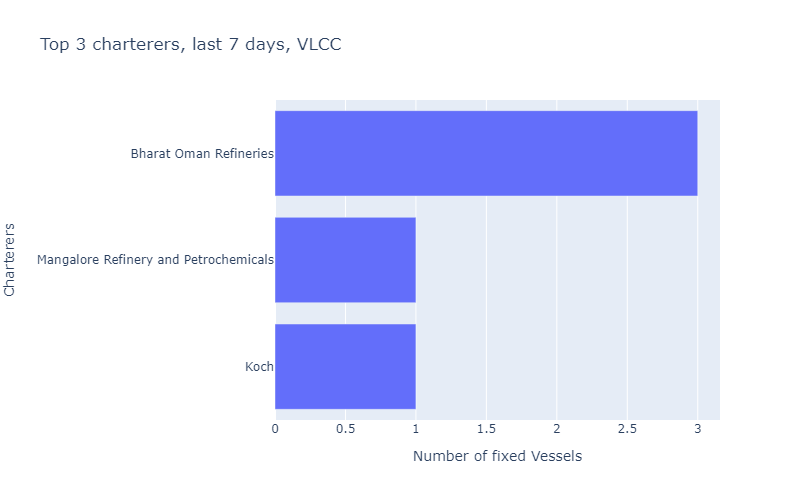

In [18]:
k = 3
plot_charterers(results, top_k_charterers=k, days=last_days)

#### Get the weekly number of fixed vessels for Ras Tanura/VLCC

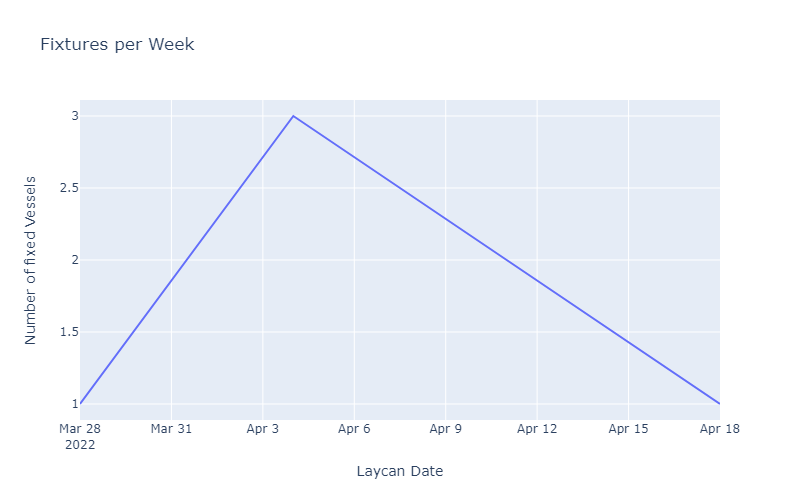

In [19]:
plot_weekly_fixed_vessels(results)

### Example 2 

In the following example we will extract the scraped fixtures for Aframax for the last week.

In [20]:
vessel_type_id = 1 
last_days = 7
vessel_class_id = 86
date_from = date.today() - timedelta(days=last_days)
date_to = date.today()
afra_results = get_scraped_fixtures(vessel_type_id,
                              date_from,
                              date_to,
                              vessel_class_id)
afra_results.head()

Wall time: 1min 22s


,fixture_id,message_id,updated_date,received_date,reported_fixture_date,imo,vessel_class_id,laycan_from,laycan_to,load_geo_id,...,redelivery_from_taxonomy,redelivery_to_name,redelivery_to_taxonomy,charterer_type,fixture_status,content,sender,is_private,is_invalidated,is_partial
0,84444783,22731952,2022-03-28 03:50:22+00:00,2022-03-28 00:00:00+00:00,None,9719692,86,2022-03-29 00:00:00+00:00,2022-03-30 00:00:00+00:00,3360.0,...,None,None,None,None,OnSubs,sti symphony 90 cpp skikda/japan 29-30/03 2.70...,Eastport Maritime,True,False,False
1,84444785,22731952,2022-03-28 03:50:22+00:00,2022-03-28 00:00:00+00:00,None,9383950,86,2022-04-14 00:00:00+00:00,2022-04-16 00:00:00+00:00,3209.0,...,None,None,None,None,OnSubs,star prosperity 80 cond dampier/japan 14-16/04...,Eastport Maritime,True,False,False
2,84444786,22731952,2022-03-28 03:50:22+00:00,2022-03-28 00:00:00+00:00,None,9531636,86,2022-04-11 00:00:00+00:00,2022-04-13 00:00:00+00:00,3530.0,...,None,None,None,None,OnSubs,sks demini 75 ulsd sikka/oz 11-13/04 rnr ampol...,Eastport Maritime,True,False,False
3,84444797,22731952,2022-03-28 03:50:22+00:00,2022-03-28 00:00:00+00:00,None,9888742,86,2022-04-08 00:00:00+00:00,2022-04-10 00:00:00+00:00,24777.0,...,None,None,None,None,OnSubs,anwaar benghazi 75 nap ag/japan 08-10/04 w165 ...,Eastport Maritime,True,False,False
4,84524424,22757656,2022-03-28 15:52:23+00:00,2022-03-28 00:00:00+00:00,None,9592252,86,NaT,NaT,NaN,...,None,None,None,None,OnSubs,None,SSY,False,False,True


#### Export results to csv


In [11]:
output_path = '' # Change output_path with your path
filename = 'afra_one_week_scraped_fix.csv'
afra_results.to_csv(output_path+filename,index=False)